[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part1/blob/main/MOOC_Notebooks/Notebook10_AHyperparameterSearch.ipynb)

# Notebook 10: A hyperparameter search

Authors: Randy J. Chase, David R. Harrison, Amanda Burke, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning](https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml)<br>
Original Github: [WAF_ML_Tutorial_Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part1)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Burke, A., Lackmann, G. M., & McGovern, A. (2022). A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning, Weather and Forecasting, 37(8), 1509-1529.

### Goal: Show an example of hyperparameter tuning 

#### Background

If you look at any of the ML method documentation, you will find there are alot of switches and nobs you can play with. See this page on ```RandomForestRegressor``` [click](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Most of these switches and nobs are considered *hyperparameters*. In otherwords, these are parameters you can change that may or may not influence the machine learning model performance. Since every machine learning task is different, you often can *tune* your choice of these hyperparameters to get a better performing model. This notebook sets out to show you one way to do a hyperparameter search with random forest. 

#### Step 0: Get the github repo (we need some of the functions there)

The first step with all of these Google Colab notebooks will be to grab the github repo and cd into the notebooks directory. 

To run things from the command line, put a ```!``` before your code

 

In [1]:
#get the github repo 
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part1.git 

#cd into the repo so the paths work 
import os 
os.chdir('/content/WAF_ML_Tutorial_Part1/jupyter_notebooks/')

Cloning into 'WAF_ML_Tutorial_Part1'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 301 (delta 139), reused 236 (delta 96), pack-reused 0
Receiving objects: 100% (301/301), 195.77 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (100/100), done.


# Import packages and load data for Regression
In the paper we do this hyperparameter tuning with the random forest regression example. So let's load in the regression dataset.

In [2]:
###################################### Load training data ######################################
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
import numpy as np
(X_train,y_train),(X_validate,y_validate),_ = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

#remember since we have all 36 predictors we need to scale the inputs 
from sklearn.preprocessing import StandardScaler
#create scaling object 
scaler = StandardScaler()
#fit scaler to training data
scaler.fit(X_train)
#transform feature data into scaled space 
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
################################################################################################

#import other packages we will need 
import pandas as pd 
import matplotlib.pyplot as plt

import matplotlib.patheffects as path_effects
pe1 = [path_effects.withStroke(linewidth=2,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=2,
                             foreground="w")]

# Determine what parameter 'sweeps' you wish to do 

Right now I would like you to go check out the random forest document page: [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). 

We will go ahead and systematically vary some of these hyperparameters. More specifically, we will play with

1. Tree depth (i.e., number of branches).
2. Number of Trees 

While one could always do more hyperparameter tests, for now this will get you started on generally how to do it. Let's vary the depth of trees from 1 to 10, and we will incrementally increase it. Then for the number of trees lets do 1, 5, 10, 25, 50, 100. Note we did 1000 in the paper, but something you will notice is that the deeper the tree and the more numerous trees it takes longer to train your models. So for it not to take forever in this tutorial, we will cut it to 100. 


In [3]:
#vary depth of trees from 1 to 10. 
depth = np.arange(1,11,1)
#vary the number of trees in the forest from 1 to 100 
n_tree = [1,5,10,25,50,100]

#build out the parameter sets we will test. 
sets = []
#for each number of trees, set their depth
for n in n_tree:
    for d in depth:
        sets.append([n,d])
        
print(sets,len(sets))

[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [10, 1], [10, 2], [10, 3], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9], [10, 10], [25, 1], [25, 2], [25, 3], [25, 4], [25, 5], [25, 6], [25, 7], [25, 8], [25, 9], [25, 10], [50, 1], [50, 2], [50, 3], [50, 4], [50, 5], [50, 6], [50, 7], [50, 8], [50, 9], [50, 10], [100, 1], [100, 2], [100, 3], [100, 4], [100, 5], [100, 6], [100, 7], [100, 8], [100, 9], [100, 10]] 60


As you can see, we have built out 60 different parameters to try out! 

To make the code a bit more concise, let's define a functiont that will calculate all our metrics for us. 

In [4]:
from gewitter_functions import get_bias,get_mae,get_rmse,get_r2
#define a function to calcualte all the metrics, and return a vector with all 4. 
def get_metrics(model,X,y):
    yhat = model.predict(X)
    mae = get_mae(y,yhat)
    rmse = get_rmse(y,yhat)
    bias = get_bias(y,yhat)
    r2 = get_r2(y,yhat)
    return np.array([bias,mae,rmse,r2])

Okay, now we are ready to do the hyperparameter sweep. 

WARNING, this took 60 mins on google colab with n_jobs set to 4. So if you dont have that kind of time, go ahead and jump past this cell, and just load the pre-computed metrics I have. 

In [5]:
# import the progress bar so we can see how long this will take
import tqdm 

#import RandomForest 
from sklearn.ensemble import RandomForestRegressor

#do our hyperparameter search!
# for each set of parameters,train a new model and evaluate it 
for i,s in enumerate(tqdm.tqdm(sets)):
    #initialize the model 
    reg = RandomForestRegressor(n_estimators=s[0],max_depth=s[1],n_jobs=4)
    #train the model
    reg.fit(X_train,y_train)
    #get the metrics on both the training dataset and the validation dataset. 
    met_train = get_metrics(reg,X_train,y_train)
    met_val = get_metrics(reg,X_validate,y_validate)
    
    #this if statement lets us stack the observations up. 
    if i ==0:
        #if the first loop, rename things
        all_scores_val = met_val 
        all_scores_train = met_train
    else:
        #otherwise, stack it on 
        all_scores_val = np.vstack([all_scores_val,met_val])
        all_scores_train = np.vstack([all_scores_train,met_train])
        
    del reg 

#import pandas for easy writing and reading functions    
import pandas as pd

#this takes a hot min to run, so lets save them when we are done. 
df_val = pd.DataFrame(all_scores_val,columns=['Bias','MeanAbsoluteError','RootMeanSquaredError','Rsquared'])
df_val.to_csv('../datasets/hyperparametersearch/validation_metrics.csv',index=False)
df_train = pd.DataFrame(all_scores_train,columns=['Bias','MeanAbsoluteError','RootMeanSquaredError','Rsquared'])
df_train.to_csv('../datasets/hyperparametersearch/train_metrics.csv',index=False)

100%|██████████| 60/60 [55:56<00:00, 55.95s/it] 


Since that took about 30 mins, we dont want to do that EVERY time we load this notebook, so lets save the results out to a file (i.e., a comma separated values file format) to allow for quick and easy reading later on. (this dataset is already made for you in the ```datasets``` folder in the repo.). 

In [6]:
df_val = pd.read_csv('../datasets/hyperparametersearch/validation_metrics.csv').to_numpy()
df_train = pd.read_csv('../datasets/hyperparametersearch/train_metrics.csv').to_numpy()

And there we go, we have successfully trained 60 models with various different configurations to see if any one particular configuration does better than another. So, how do we check which one is doing best? Well we can look at the validation dataset results, here I named it ```all_scores_val```. This will show us the general performance on the validation data. So lets take a look at that now. In the next cell is some code to plot up that matrix we saved out in the last cell. 

The figure I want to make has a metric on each panel. The x-axis will be the tree depth, then each color will be the number of trees. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


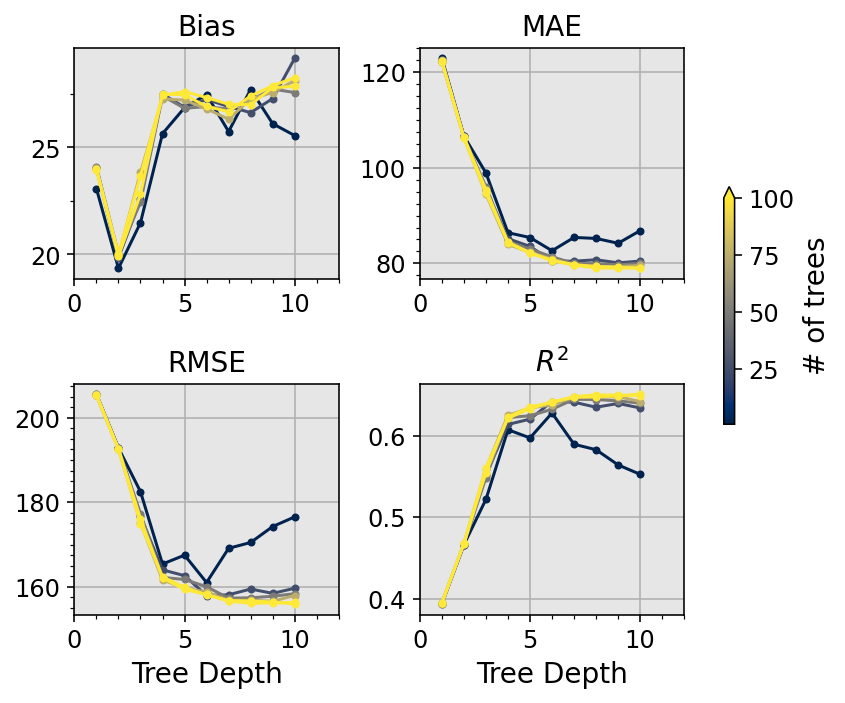

In [8]:
#matplotlib things
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make a 2 row, 2 column plot (4 total subplots)
fig,axes = plt.subplots(2,2,figsize=(5,5))
#set background color to white, otherwise its transparent when you copy paste it out of this notebook. 
fig.set_facecolor('w')

#lets ravel the 2x2 axes matrix to a 4x1 shape. This makes looping easier (in my opinion). 
axes = axes.ravel()

########### colormap stuff ###########
# I want to color each line by the number of trees. So this bit of code does that for us.
#get func to plot it
from aux_functions import make_colorbar
#grab colormap
cmap = matplotlib.cm.cividis
#set up the boundaries to each color 
norm = matplotlib.colors.BoundaryNorm(n_tree, cmap.N)
#make a mappable so we can get the color based on the number of trees. 
scalarMap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
######################################

titles = ['Bias','MAE','RMSE','$R^{2}$']
for j,ax in enumerate(axes):
    for i,ii in enumerate(n_tree):
        color_choice =scalarMap.to_rgba(ii)
        ax.plot(np.arange(1,11,1),df_val[(i*10):(i+1)*10,j],'o-',color=color_choice,ms=3)
        # ax.plot(np.arange(1,11,1),df_train[(i*10):(i+1)*10,j],'o--',color=color_choice,ms=3)
        ax.set_title(titles[j])
        ax.set_xlim([0,12])
        ax.grid('on')
        # ax.xaxis.grid(True, which='minor')
        # For the minor ticks, use no labels; default NullFormatter.
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(2.5))
        
axes[2].set_xlabel('Tree Depth')
axes[3].set_xlabel('Tree Depth')

########### draw and fill the colorbar ###########
ax_cbar = fig.add_axes([1.025, 0.4, 0.015,0.33])
cbar = make_colorbar(ax_cbar,1,100,cmap)
cbar.set_label('# of trees')
##################################################

plt.tight_layout()

A reminder that each x-axis as the tree depth (i.e., number of decisions; branches) and the y-axis is the metric that is indicated in the title. The color corresponds to the number of trees used in the random forest, with 1 being the darkest color and 100 being the lightest. 

As we can see, and noted in the paper, basically beyond using just 1 tree, which means its a decision tree, the number of trees doesnt have a large effect on the overall performance, while the number of trees seems to have a more appreciable effect. While this is helpful to find generally which models are performing better than others, there is a group of models that all seem to have similar performance with a tree depth greater than 5.  

In order to truly assess which one is best to use, we need to include the training data metrics. This is where we will diagnose when a model becomes *overfit*. Overfitting is when the training data performance is really good, but the validation performance is not good. To diagnose this, you compare on the plot when the training data continues to improve its performance while the validation performance starts to degrade or worsen. So lets add the training curves to the same plot as above.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


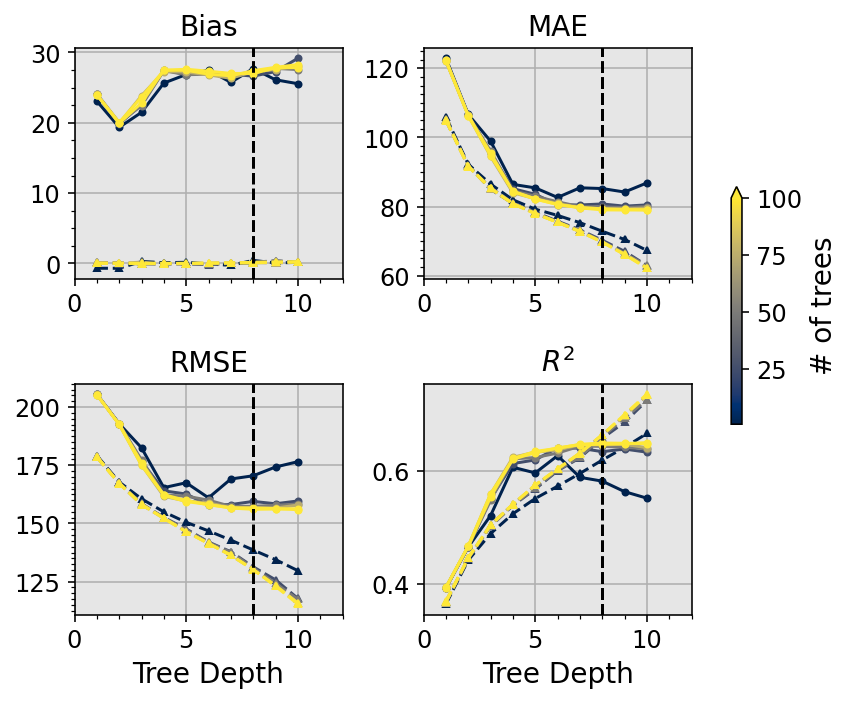

In [10]:
#make a 2 row, 2 column plot (4 total subplots)
fig,axes = plt.subplots(2,2,figsize=(5,5))
#set background color to white, otherwise its transparent when you copy paste it out of this notebook. 
fig.set_facecolor('w')

#lets ravel the 2x2 axes matrix to a 4x1 shape. This makes looping easier (in my opinion). 
axes = axes.ravel()

########### colormap stuff ###########
# I want to color each line by the number of trees. So this bit of code does that for us.
#get func to plot it
from aux_functions import make_colorbar
#grab colormap
cmap = matplotlib.cm.cividis
#set up the boundaries to each color 
norm = matplotlib.colors.BoundaryNorm(n_tree, cmap.N)
#make a mappable so we can get the color based on the number of trees. 
scalarMap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
######################################

titles = ['Bias','MAE','RMSE','$R^{2}$']
for j,ax in enumerate(axes):
    for i,ii in enumerate(n_tree):
        color_choice =scalarMap.to_rgba(ii)
        ax.plot(np.arange(1,11,1),df_val[(i*10):(i+1)*10,j],'o-',color=color_choice,ms=3)
        ax.plot(np.arange(1,11,1),df_train[(i*10):(i+1)*10,j],'^--',color=color_choice,ms=3)
        ax.axvline(8,ls='--',color='k')
        ax.set_title(titles[j])
        ax.set_xlim([0,12])
        ax.grid('on')
        # ax.xaxis.grid(True, which='minor')
        # For the minor ticks, use no labels; default NullFormatter.
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(2.5))
        
axes[2].set_xlabel('Tree Depth')
axes[3].set_xlabel('Tree Depth')

########### draw and fill the colorbar ###########
ax_cbar = fig.add_axes([1.025, 0.4, 0.015,0.33])
cbar = make_colorbar(ax_cbar,1,100,cmap)
cbar.set_label('# of trees')
##################################################

plt.tight_layout()

Okay, now we have the training curves in the dashed lines and triangle markers. I have also drawn a vertical dashed black line on the tree depth that seems to maximize performance before overfitting. We can see at a tree depth of 8, the $R^{2}$ value for the training data now out performs the validation data, while the other metrics are effectively the same as 5,6, and 7. Thats why we suggest random forest of > 1 tree and depth of 8 is likely a good model to continue on and use. 

I hope this was enough to give you an example of how to do hyperparameter tuning. I encourage you to go ahead and try it with the other models!